***

* [Outline](../0_Introduction/0_introduction.ipynb)
* [Glossary](../0_Introduction/1_glossary.ipynb)
* [5. Imaging](5_0_introduction.ipynb)
    * Previous: [5.4 Imaging weights](5_4_imaging_weights.ipynb) 
    * Next: [5.5 References and further reading](5_x_further_reading_and_references.ipynb)

***

Import standard modules:

In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML 
HTML('../style/course.css') #apply general CSS

Import section specific modules:

In [13]:
from IPython.display import Image
from mpl_toolkits.mplot3d import Axes3D
import track_simulator

from astropy.io import fits
import aplpy

#Disable astropy/aplpy logging
import logging
logger0 = logging.getLogger('astropy')
logger0.setLevel(logging.CRITICAL)
logger1 = logging.getLogger('aplpy')
logger1.setLevel(logging.CRITICAL)

In [ ]:
HTML('../style/code_toggle.html')

## 5.5 小角度近似失效与w项 The Break Down of the Small Angle Approximation and the W-Term

到目前为止，我们使用了重采样和快速傅立叶变换在图像和可见度域之间搬动数据。回想一下，我们用下面这个简化的傅立叶关系式来证明该过程的合理性：

Up to this point we used a resampling step and the Fast Fourier Transform to move between the image and visibility domains. Recall that we used the following simplified Fourier relationship to justify this synthesis process:

\begin{equation}
 \begin{split}
     V(u,v) &= \int_\text{sky}{I(l,m)e^{-2\pi i/\lambda(\vec{b}\dot(\vec{s}-\vec{s}_0))}}dS\\
            &= \int\int{I(l,m)e^{-2\pi i/\lambda(ul+vm+w(\sqrt{1-l^2-m^2}-1))}}\frac{dldm}{\sqrt{1-l^2-m^2}}\\
            &\approx\int\int{I(l,m)e^{-2\pi i/\lambda(ul+vm)}}dldm\\
 \end{split}
\end{equation}

上式中最后的近似，是到目前为止，我们在成像处理中用到的一个模型，是一个傅立叶变换。然而，将测量与天球的亮度分布联系起来的更精确的模型并“不是”这一经典的傅立叶变换。这种近似只在当$n - 1 = \sqrt{1-l^2-m^2} - 1 \ll 1$（即小天区成像）且/或 $w \approx 0$（阵列共面） 成立时才有效。$(n-1)$ 是源在天球上的实际位置跟天球近似切面间的投影高度差，请参见下图。

The last approximation to the model is just a Fourier transform by definition and is the one used when we were imaging up to this point. However, the more accurate version that relates the measurement to the brightness distribution along the celestial sphere is ***not*** the classical Fourier transform. The approximation is only valid when $n - 1 = \sqrt{1-l^2-m^2} - 1 \ll 1$ (ie. images of small regions of the sky) and/or $w \approx 0$ (the array is coplanar). Here $(n-1)$ is the projection height difference between the planar approximation tangent to the celestial sphere and a source's true position on the sphere, see the illustration below.

<img src="figures/orthogonal_projection_difference.png" alt="Smiley face" width="512">

图：单位天球上的方向余弦（这里只画出了$l$和$n$），$n=\sqrt{1-l^2-m^2}$。如果投影极（图像的切点）就是相位参考中心，$n_0 = 1$。源在图像切面上的正交投影与源在天球上的实际位置之间的总误差为$\epsilon=(n-n_0)=(\sqrt{1-l^2-m^2} - 1)$。

*Figure: The direction cosines (here $l$ is plotted against $n$) lie along the unit celestial sphere. $n$ is given by $n=\sqrt{1-l^2-m^2}$. If the projection pole (tangent point of the image) is at the same point as the phase reference centre, $n_0 = 1$. The total error between the orthogonal (SIN) projection of the source onto the tangent image plane and the source position on the celestial sphere is given as $\epsilon=(n-n_0)=(\sqrt{1-l^2-m^2} - 1)$.*

在窄视场和共面测量假设下，使用FFT构建共面的近似天空是有效的。本节将讨论，当上述假设不存在的情况下，用非共面基线进行宽视场成像时要解决的问题。

Under the assumptions of a narrow field of view and coplanar measurements it is valid to use the FFT to construct a planar approximation to the sky. This section discusses the problem of *wide-field imaging using non-coplanar baselines* that arises when these assumptions are broken.

### 5.5.1 共面采样 Coplanar Sampling

考虑以下两个假想的理想阵列：一个是只由东西方向基线构成的共面阵列，另一个是包含非东西向基线的二维共面阵列。

Consider the following two hypothetical arrays: a perfectly flat array that only has baselines along the east-west direction, and a second perfectly flat two-dimensional array with some baselines in a non-east-west direction.

In [3]:
NO_ANTENNA = 4
NO_BASELINES = NO_ANTENNA * (NO_ANTENNA - 1) / 2 + NO_ANTENNA
CENTRE_CHANNEL = 1e9 / 299792458 #Wavelength of 1 GHz
#Create a perfectly planar array with both a perfectly East-West baseline and 2 2D baselines
ENU_2d = np.array([[5,0,0],
                [-5,0,0],
                [10,0,0],
                [0,23,0]]);
ENU_ew = np.array([[5,0,0],
                 [-5,0,0],
                 [10,0,0],
                 [0,0,0]]);
ARRAY_LATITUDE = 30 #Equator->North
ARRAY_LONGITUDE = 0 #Greenwitch->East, prime -> local meridian

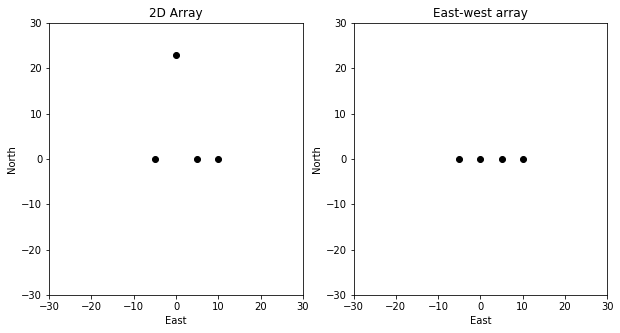

In [4]:
fig = plt.figure(figsize=(10, 5))
ax=fig.add_subplot(121)
ax.set_title("2D Array")
ax.plot(ENU_2d[:,0],ENU_2d[:,1],"ko")
ax.set_xlabel("East")
ax.set_ylabel("North")
ax.set_xlim(-30,30)
ax.set_ylim(-30,30)
ax=fig.add_subplot(122)
ax.set_title("East-west array")
ax.plot(ENU_ew[:,0],ENU_ew[:,1],"ko")
ax.set_xlabel("East")
ax.set_ylabel("North")
ax.set_xlim(-30,30)
ax.set_ylim(-30,30)
plt.show()

图：两个阵列的ENU坐标：一个是二维阵列，一个是东-西阵列。

*Figure: ENU coordinates for two hypothetical flat arrays: a 2D array and an east-west array*

比起一维东西阵列，二维干涉阵主要有以下两大优势：
1、在低赤纬观测下，可以提高uv覆盖，如下图所示。
2、在相位参考中心跟基线正交的情况下，干涉仪响应最大。
在较低观测角度下，会得到与东西方向对不齐的基线分量。

The two-dimensional interferometer has two major advantages over its one-dimensional east-west counterpart:
1. Improved u,v coverage at lower declinations, as plotted below.
2. Recall that the interferometer response is maximum when the phase-reference centre is orthogonal to the baseline.
At lower observation angles it is desirable to have baseline components that are not aligned from east-to-west.

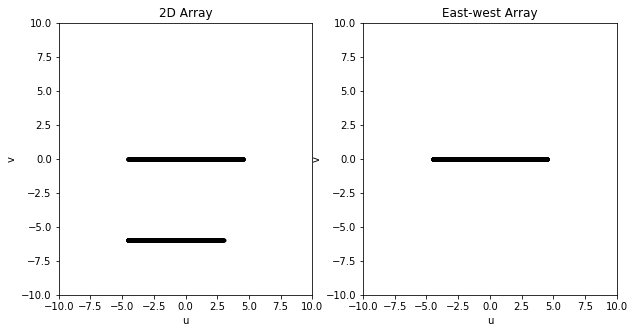

In [5]:
DECLINATION = 0
T_OBS = 12
T_INT = 1/60.0
uw_2hr_2d = track_simulator.sim_uv(0.0,DECLINATION,T_OBS,T_INT,ENU_2d,ARRAY_LATITUDE,False)/CENTRE_CHANNEL
uv_2hr_ew = track_simulator.sim_uv(0.0,DECLINATION,T_OBS,T_INT,ENU_ew,ARRAY_LATITUDE,False)/CENTRE_CHANNEL
fig = plt.figure(figsize=(10, 5))
ax=fig.add_subplot(121)
ax.set_title("2D Array")
ax.plot(uw_2hr_2d[:,0],uw_2hr_2d[:,1],'k.')
ax.set_xlabel("u")
ax.set_ylabel("v")
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
ax=fig.add_subplot(122)
ax.set_title("East-west Array")
ax.plot(uv_2hr_ew[:,0],uv_2hr_ew[:,1],'k.')
ax.set_xlabel("u")
ax.set_ylabel("v")
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
plt.show()

图：赤纬$\delta=0$时，2D和东西阵列的uv覆盖。

*Figure: u,v coverage at declinatin $\delta=0$ for both a 2D and east-west array*

使用二维阵列的一个缺点在于，尽管阵列呈完美的共面布局，但是观测期间所获得的测量数据并不能维持共面。下面的三维空间图呈现了uvw轨迹及其投影。而东西向干涉仪的uvw轨迹则相反，始终维持在与地球赤道平行的同一个平面上。然而，如果观测时间足够短，也就是所谓的“快照”观测情况下，地球自转行程足够短，二维干涉仪的测量结果可以近似为共面。

The one drawback to using these two-dimensional layouts is that the measurements taken over the duration of the observation do not remain coplanar, even though the array layout is perfectly flat. The uvw tracks and their projections are plotted in 3-space below to illustrate this. This is opposed to the tracks created by the east-west interferometer which all remain in the same plane parallel to the Earth's equator. Alas, if an observation is sufficiently short, called a *snapshot* observation, then the rotation of the Earth is short enough to approximate the measurements of a two-dimensional interferometer as coplanar.

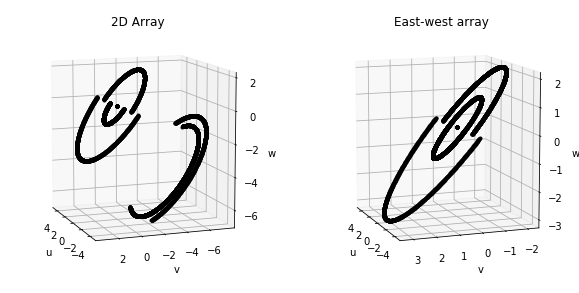

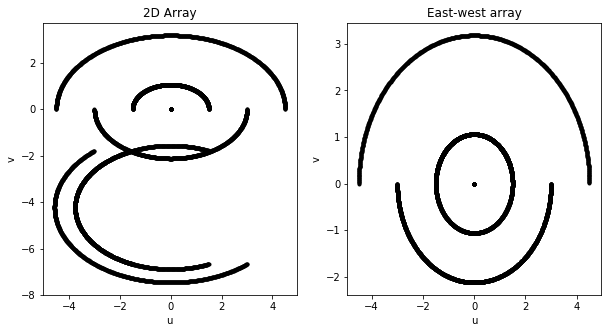

In [6]:
DECLINATION = 45
T_INT = 1/60.0
T_OBS = 12
uvw_2d = track_simulator.sim_uv(0.0,DECLINATION,T_OBS,T_INT,ENU_2d,ARRAY_LATITUDE,False)/CENTRE_CHANNEL
uvw_ew = track_simulator.sim_uv(0.0,DECLINATION,T_OBS,T_INT,ENU_ew,ARRAY_LATITUDE,False)/CENTRE_CHANNEL
fig=plt.figure(figsize=(10, 5))
ax=fig.add_subplot(121,projection='3d')
ax.set_title("2D Array")
ax.view_init(elev=10, azim=160)
ax.plot(uvw_2d[:,0],uvw_2d[:,1],uvw_2d[:,2],'k.')
ax.set_xlabel("u")
ax.set_ylabel("v")
ax.set_zlabel("w")
ax=fig.add_subplot(122,projection='3d')
ax.set_title("East-west array")
ax.view_init(elev=10, azim=160)
ax.plot(uvw_ew[:,0],uvw_ew[:,1],uvw_ew[:,2],'k.')
ax.set_xlabel("u")
ax.set_ylabel("v")
ax.set_zlabel("w")
plt.show()

fig = plt.figure(figsize=(10, 5))
ax=fig.add_subplot(121)
ax.set_title("2D Array")
ax.plot(uvw_2d[:,0],uvw_2d[:,1],'k.')
ax.set_xlabel("u")
ax.set_ylabel("v")
ax=fig.add_subplot(122)
ax.set_title("East-west array")
ax.plot(uvw_ew[:,0],uvw_ew[:,1],'k.')
ax.set_xlabel("u")
ax.set_ylabel("v")
plt.show()

图：2D干涉仪和东西向干涉仪的uvw轨迹及其在($u,v,w=0$)上的投影。

*Figure: $u,v,w$ tracks and their projections onto ($u,v,w=0$) for a 2D and east-west interferometer*

当在单个平面上对测量结果进行采样（如东西向干涉仪）时，所有的$w$项可以写成u和v的同一个线性组合：$w = \alpha{u}+\beta{v}$。虽然这样一来，在天空和测量之间的傅立叶关系中引入了轻微失真，但这失真的关系并没有破坏二维傅立叶变换的有效性。可以表示为：

When the measurement domain is sampled along a single plane, as is true for the east-west interferometer, then all $w$ can be written as the same linear combination of u and v: $w = \alpha{u}+\beta{v}$. Although this introduces a slight distortion of the u,v coordinates in the Fourier relationship between the sky and the measurements, the distorted relationship remains a valid two-dimensional Fourier transform. It can be stated as:

\begin{equation}
    \begin{split}
        V(u,v,w) &= \int\int{I(l,m)e^{-2\pi i/\lambda(ul' + vm')}\frac{dldm}{\sqrt{1-l^2-m^2}}}\\
        l' &= l + \alpha(\sqrt{1-l^2-m^2} - 1)\\
        m' &= m + \beta(\sqrt{1-l^2-m^2} - 1)\\
    \end{split}
\end{equation}

### 5.5.2 非共面采样 Non-coplanar Sampling

二维阵列的情况则有所不同，$w$ 跟 $u、v$之间不存在固定关系，而是依赖于随时间变化的天顶角和视差角，只有在瞬时观测，并且阵列布局近似平面的情况下，uv覆盖才能保持共面。

The same can not be said for two-dimensional arrays. There is no fixed relationship between $w$ and $u,v$. Instead the relationship depends both on the time-variant zenithal and parallactic angles, and the $u,v$ coverage *only* remains co-planar for instantaneous observations, provided the array layout is approximately flat.

用平面近似合成二维阵列宽视场图像时，忽略$w(n-1)$会给测量带来方向依赖误差，这种相位误差跟天线间的高度差有关，如下图所示。

Neglecting the $w(n-1)$ term by synthesizing wide-field images with two-dimensional arrays, using a planar approximation, introduces a direction-dependent error in the measurement. This phase error depends on the height-difference between antennae, as is illustrated by the tilted interferometer below. 

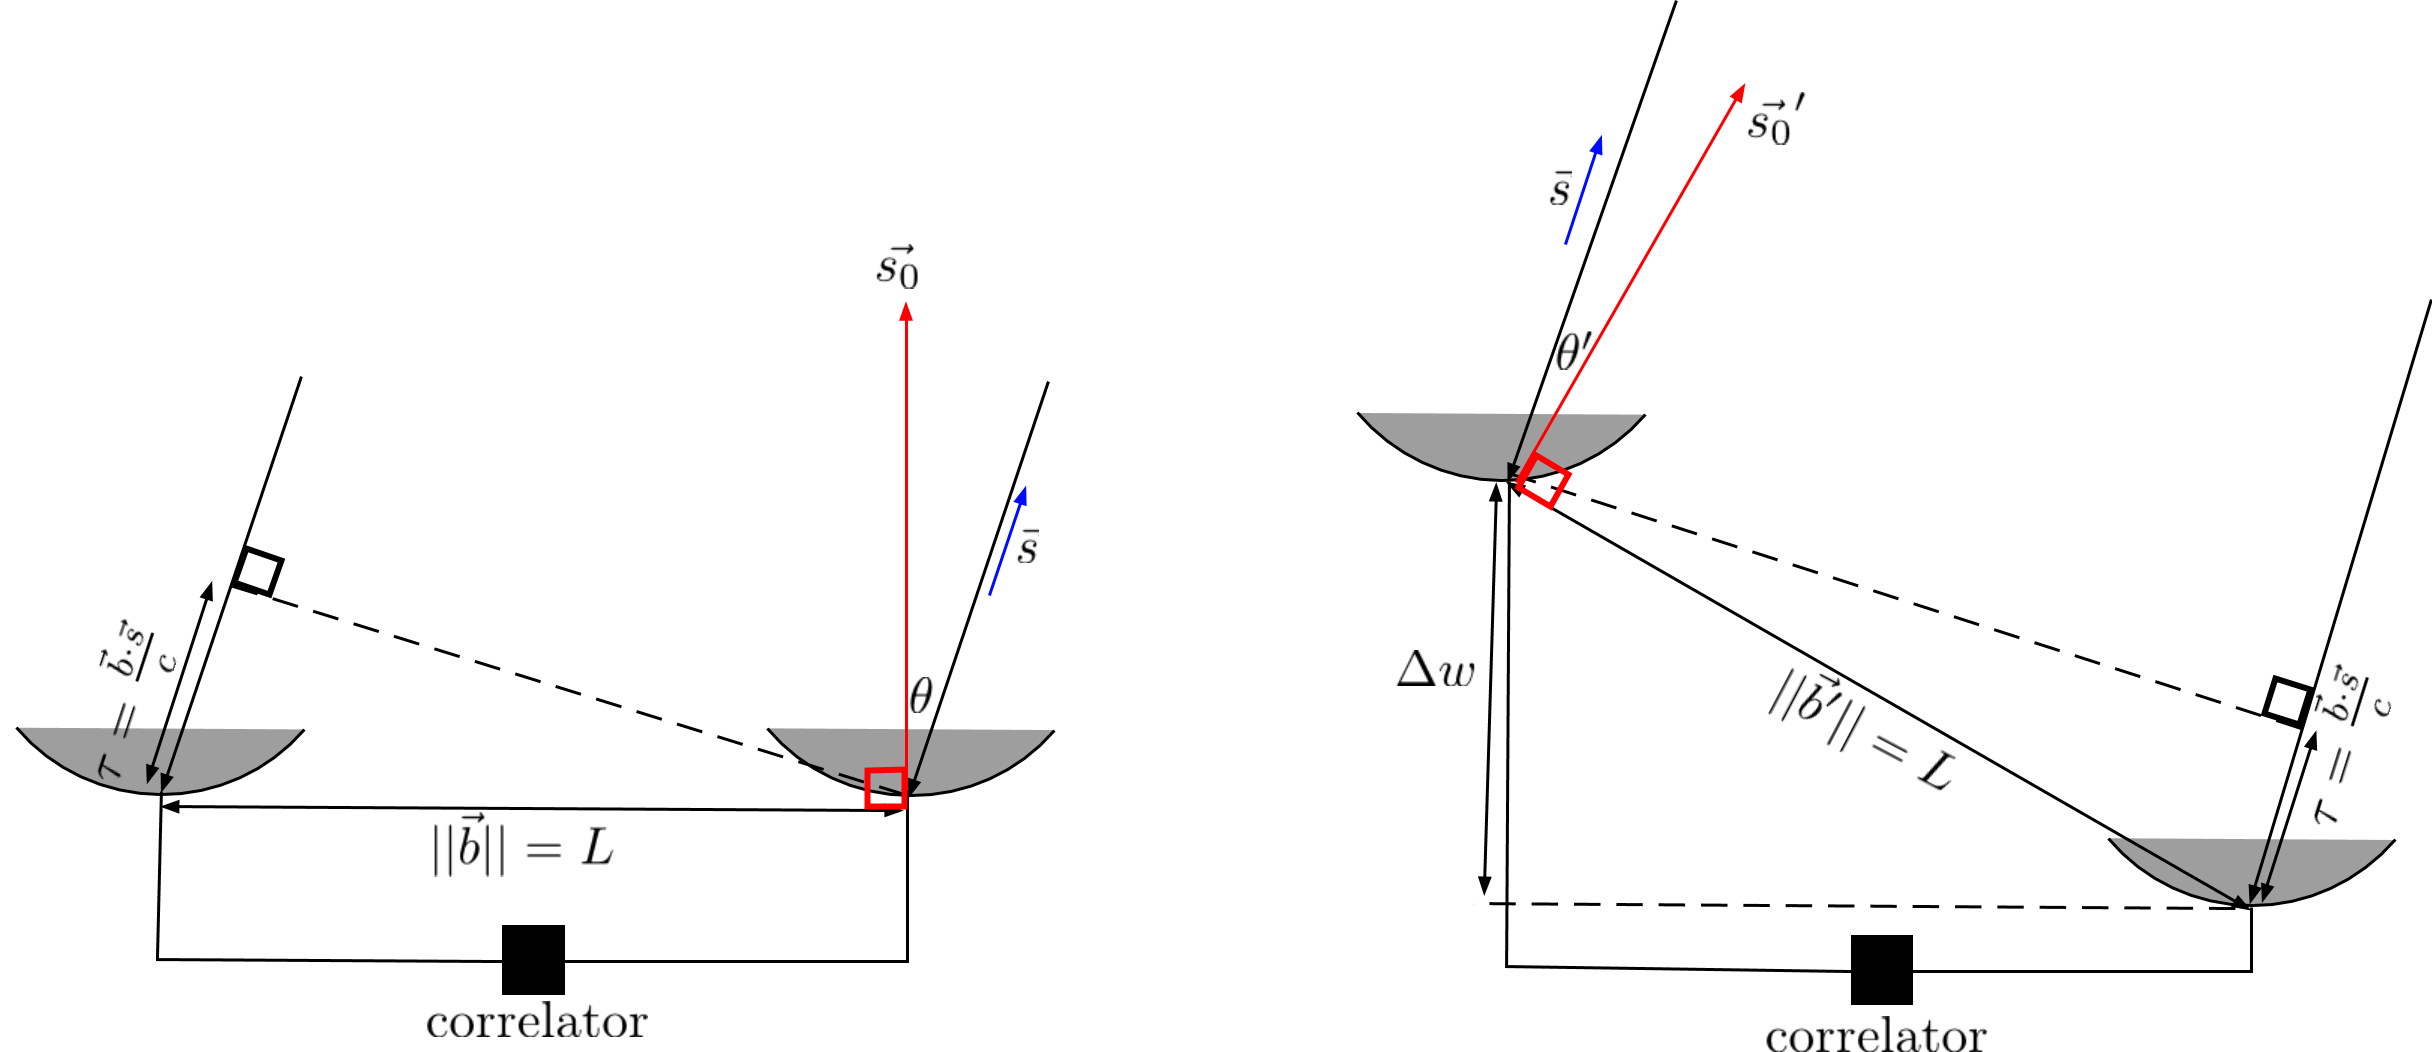

In [7]:
Image(filename="figures/tilted_interferometer.png")

DH：我把原文中的$\phi$ 改成了$\theta$

图：如上图所示，对于共面干涉仪和倾斜干涉仪，源矢量在基线上的投影有所不同。共面干涉仪基线沿视线（$\vec{s}$）所获取的信号的相位为$\theta = \frac{-2\pi i}{\lambda}(ul + vm)$，而倾斜基线沿同一视线所获取信号的相位为$\theta_\text{tilt} = \frac{-2\pi i}{\lambda}{[ul + vm + w(n-1)]}$。基线越长，距离相位中心越远，信号传播时延越大。

*Figure: As the two figures show the projection of the source vector onto the two baselines are different for the coplanar and tilted interferometers. The phase for signals taken by co-planar interferometer baselines along some line of sight, $\vec{s}$, is given as $\phi = \frac{-2\pi i}{\lambda}(ul + vm)$, as opposed to tilted baselines that measure this same phase as $\phi_\text{tilt} = \frac{-2\pi i}{\lambda}{[ul + vm + w(n-1)]}$. The signal propagation delay is worse on the longest baselines and along the direction of sources far away from the phase centre of the interferometer.*

值得注意的是，从本质上讲，该相位项只是纯几何形状，对于非共面测量，插入延迟改正$\Delta{w}$项，只对单视线改正有效。换句话说，这种改正只是改变了干涉仪的相位中心。

It is important to realize that this phase term is purely geometric in origin; inserting a delay to correct $\Delta{w}$ for non-coplanar measurements only serves to correct the error in a single line of sight. In other words only the phase centre of the interferometer is changed by such a correction.

相位误差如何影响远离相位中心的源的亮度，小角度近似$\sqrt{1+x} \approx 1+ \frac{x}{2}$给了我们一些直观感受。

The small angle approximation $\sqrt{1+x} \approx 1+ \frac{x}{2}$ gives some intuition on how this phase error effects the brightness of sources away from the phase centre. It can be shown that:
\begin{equation}
    V(u,v,w) \approx {\int\int{I(l,m)(e^{2\pi i/\lambda wl^2/2}e^{2\pi i /\lambda wm^2/2})e^{-2\pi i /\lambda(ul+vm)}\frac{dldm}{n}}}
\end{equation}

既然$w$可以表示为$u、v$、方位角以及仰角之间的一个复杂关系式，我们希望看到源位置随时间和基线的变化。该相对位置偏移量随着源的l和m的变化，大致呈平方增长。下面分别给出了来自JVLA的观测数据和来自MeerKAT的模拟观测图像，展示了在长时间大区域观测时，源出现的拖尾现象。

Since $w$ can be rewritten as a complex relationship of $u,v$ and time-variant elevation and azimuth angles we expect to see a time- and baseline-variant shift in source position. This relative position shift also grows roughly quadratically with the source offsets in l and m. The images below show how sources are smeared over large areas during long observations first on the data captured with the JVLA and then on a simulated MeerKAT observation.

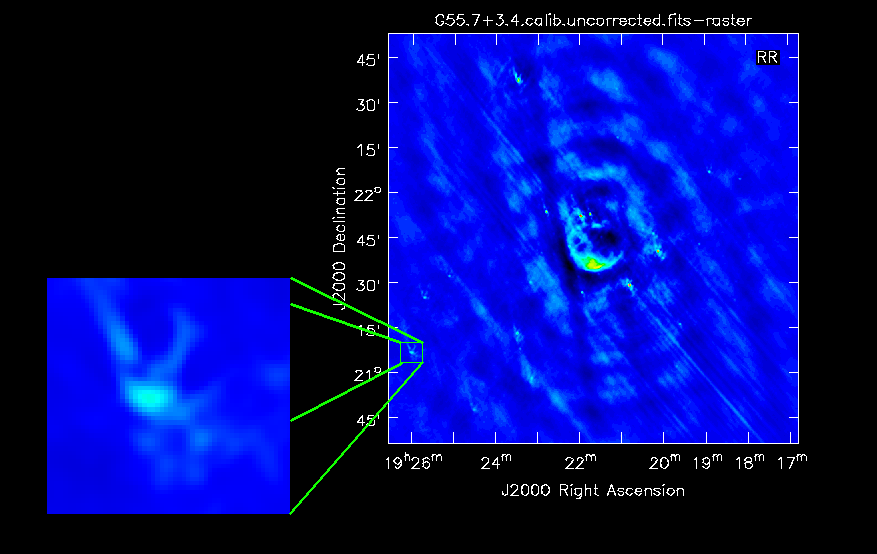

In [8]:
Image(filename="figures/vla_uncorrected.png")

图：未改正的超新星遗迹8小时观测图像，G55.7+3.4，JVLA-D。注意点源周围的椭圆形拖尾。

*Figure: Uncorrected image of the 8 hour observation of the supernova reminant G55.7+3.4 on the JVLA in D-configuration. Notice the eliptical smearing around the point source.*

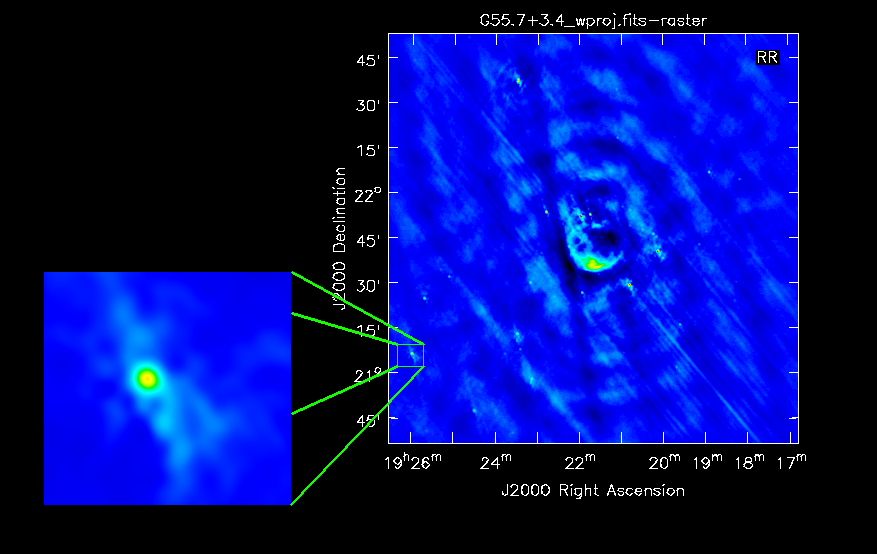

In [9]:
Image(filename="figures/vla_wproj.png")

图：W-projection 超新星遗迹8小时观测图像，G55.7+3.4，JVLA-D。
*Figure: W-projection image of the 8 hour observation of the supernova reminant G55.7+3.4 on the JVLA in D-configuration.*

<class 'aplpy.core.FITSFigure'>


TypeError: WCS projection has 4 dimensions, so expected 2 (an Nx4 array and the origin argument) or 5 arguments (the position in each dimension, and the origin argument). Instead, 3 arguments were given.

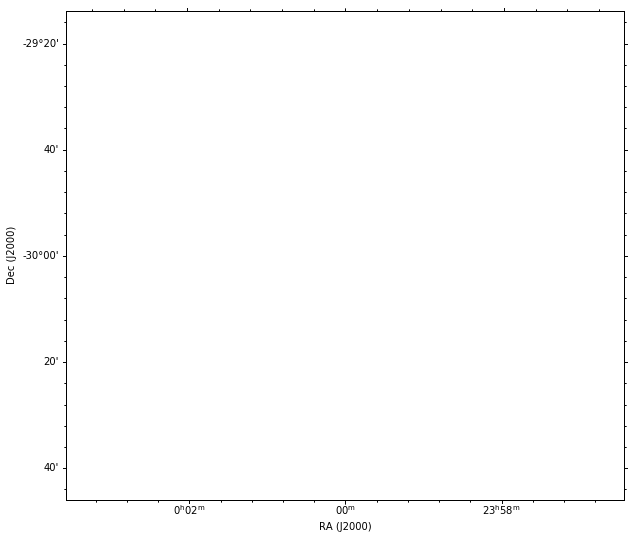

In [25]:
gc1 = aplpy.FITSFigure('../data/fits/wterm/MeerKAT_6h60s_dec-30_10MHz_10chans_uniform_n3000_w0-image.fits')
print(type(gc1))

cpx = gc1.pixel2world(256, 256)
gc1.recenter(cpx[0], cpx[1], radius=0.2)
gc1.show_colorscale(vmin=-0.2, vmax=1., cmap='viridis')
gc1.hide_axis_labels()
gc1.hide_tick_labels()
plt.title('MeerKAT Observation (Not Corrected)')
gc1.add_colorbar()

图：MeerKAT模拟观测图像，未经过w-projection改正，相位中心在右上角。相比相位附近的源，远离相位中心的源存在大量拖尾。

*Figure: A quadrant of an image, not w-projection corrected, from a MeerKAT simulated observation, the phase centre is at the top right corner. Sources further from the phase centre have a larger amount of smearing compared to closer in.*

TypeError: WCS projection has 4 dimensions, so expected 2 (an Nx4 array and the origin argument) or 5 arguments (the position in each dimension, and the origin argument). Instead, 3 arguments were given.

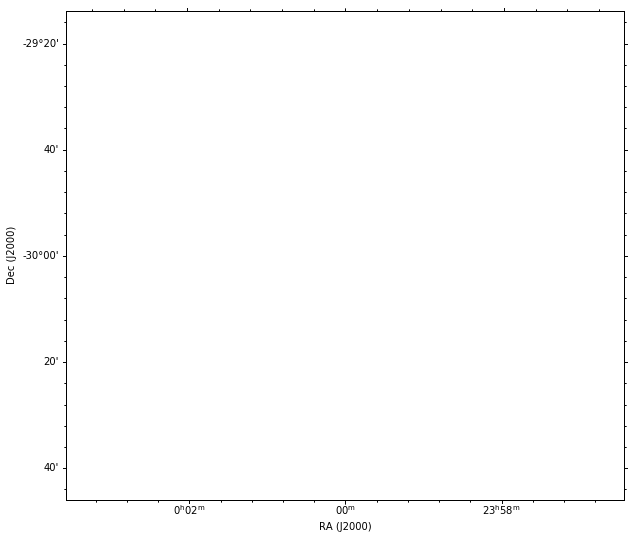

In [11]:
gc1 = aplpy.FITSFigure('../data/fits/wterm/MeerKAT_6h60s_dec-30_10MHz_10chans_uniform_n3000-image.fits')
cpx = gc1.pixel2world(256, 256)
gc1.recenter(cpx[0], cpx[1], radius=0.2)
gc1.show_colorscale(vmin=-0.2, vmax=1., cmap='viridis')
gc1.hide_axis_labels()
gc1.hide_tick_labels()
plt.title('MeerKAT Observation (W-Corrected)')
gc1.add_colorbar()

图：MeerKAT模拟观测图像，经过w-projection改正，相位中心在右上角。相比未经过改正的图，远离相位中心的源保持点的形状。

*Figure: A quadrant of an image, w-projection corrected, from a MeerKAT simulated observation, the phase centre is at the top right corner. Sources far from the phase centre remain point-like when the correction is accounted for as compared to the un-corrected image above.*

### 5.3.3 非共面基线效应改正 Correcting Non-coplanar Baselines Effects

重采样时丢掉$w(n-1)$和2D快速傅立叶变换会引入延迟误差，针对这些误差有很多钟改正的方法，包括：

There are various ways the delay error introduced when discarding the $w(n-1)$ term during resampling and 2D Fast Fourier Transform can be corrected for, these include:

**全3D变换：** 跟2D直接傅立叶变换类似，傅立叶变换也可以在$l,m,n$的立体空间进行每个分量的计算，天空是该立方体里的一个单位球面。Perley在[<cite data-cite='taylor1999synthesis'>Synthesis Imaging in Radio Astronomy II</cite> &#10548;](http://adsabs.harvard.edu/full/1999ASPC..180..383P)详细推导了该项在计算和内存消耗方面都没有技术可行性的方法。

**Full 3D transform:** Similar to the 2D Direct Fourier Transform the Fourier transform can be computed for every element in a cube of $l,m,n$ values. The sky lies along the unit sphere within this cube. See Perley's discussion in [<cite data-cite='taylor1999synthesis'>Synthesis Imaging in Radio Astronomy II</cite> &#10548;](http://adsabs.harvard.edu/full/1999ASPC..180..383P) for a full derivation of this usually computationally and memory prohibitive technique.

**快照成像：** 如前所述，假定物理阵列位于一个平面上，则在非常短时间内观测得到的可见度测量是共面的。每次观测的$l,m$坐标会有细微变化，在对多次观测求平均之前，必须要把每幅图插值处理到相同坐标上。

**Snapshot imaging:** As alluded to earlier the visibility measurements taken during very short observations are co-planar, assuming the physical array lies on a flat plane. During each observation the $l,m$ coordnates are slightly distorted and the images have to be interpolated to the same coordinates before the images can be averaged into a single map of the sky.

**Facet 成像：**Facet成像的目标在于把$(n-1)$因子降到0，以满足2D傅立叶变换有效的窄视场假设。把天空分割成小块图像的方法很多，然而最经典的是Facet成像方法，该方法把天球面分成许多小切面，用一个多面体去逼近天空。

**Facet imaging:** In facet imaging the goal is to drive the $(n-1)$ factor down to 0; satisfying the narrow-field assumption that makes the 2D Fourier inversion valid. There are a few ways in which the sky can be split into smaller images, but the classical faceting approach is to tile the celestial sphere with many small tangent images, approximating the sky by a polyhedron. 

小切面（多面体）成像背后的算法易于实现。首先，通过转动每个分块可见度的相位，把天空中心移到每个窄视场分块图像的中心$l_i,m_i$。然后，把每个分块图像转到与天球相切，由于傅立叶变换也在跟着转，旋转可见度的uv坐标，让干涉仪指向$\alpha_i,\delta_i$，而不是原始的相位中心，使分块铺满uv轨迹。另$(l_\Delta,m_\Delta,n_\Delta) = (l_i-l_0,m_i-m_0,n_i-n_0)$，则：

The algorithm behind tangent (polyhedron) facet imaging is simple to implement. First the sky is recentred at the image centres $l_i,m_i$ of each of the narrow-field facets, by phase rotating the measured visibilities. Each of the facet-images is then rotated to be tangent to the sky sphere. As the Fourier transform preserves rotations, the facets can be tilted by rotating the u,v coordinates of the measurements to the tracks that would have been produced if the interferometer was pointing at $\alpha_i,\delta_i$, instead of the original phase tracking centre. Let $(l_\Delta,m_\Delta,n_\Delta) = (l_i-l_0,m_i-m_0,n_i-n_0)$, then:

\begin{equation}
  \begin{split}
    V(u,v,w)&\approx\int{\int{B(l-l_i,m-m_i,n-n_i)e^{-2{\pi}i[u(l-l_i)+v(m-m_i)+w(n-n_i)]}\frac{dldm}{n}}}\\
    &\approx\int{\int{B(l-l_i,m-m_i,n-n_i)e^{-2{\pi}i[u(l-l_0-l_\Delta)+v(m-m_0-m_\Delta)+w(n-n_0-n_\Delta)]}\frac{dldm}{n}}}\\
    &\approx\left[\int{\int{B(l-l_0,m-m_0,n-n_0)e^{-2{\pi}i[u(l-l_0)+v(m-m_0)+w(n-n_0)]}\frac{dldm}{n}}}\right]e^{2{\pi}i[ul_\Delta,vm_\Delta,wn_\Delta]}\\
  \end{split}
\end{equation}

注意，如果只转相位，不转分块，则远离相位中心的有效分块尺寸会逐渐变小。为了使所有边缘小块的投影误差保持可比性，靠近视场边缘的分块必须要小，这就加大了计算量。相反，如果让分块绕着天球面平铺，构成多面体，则所有小块大小一样。下面以两个卡通进行简单说明：

Note that if only the phase rotation is performed without rotating the facet geometry the effective field of view of individual facets that are far away from the phase centre will decrease. In order to keep the projection error at the edge of all the facets comparable this means that the facets closer to the edge of the field must be significantly smaller, increasing the computational demands of such an approach. Instead if the facets are rotated to form a polyhedron around the celestial sphere the facets can all be the same size. A simple visual proof of this is given by the following two cartoons:

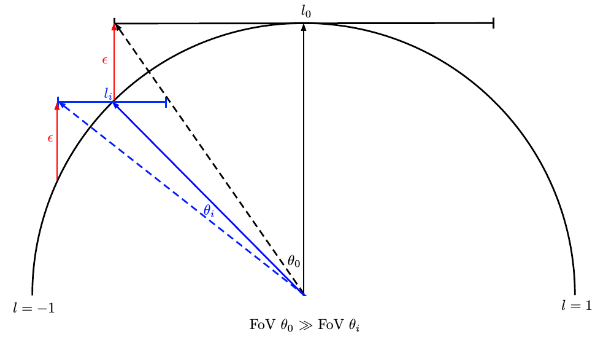

In [39]:
Image(filename="figures/coplanar-faceting.png")

图：如果只转可见度的相位中心，uvw坐标不跟着转，在投影深度$\epsilon$不变的情况下，分块会逐渐变小。图中，每个分块都与原始切面平行。当分块远离原始相位中心，边缘的有效分块将缩到非常小。

*Figure: Only phase steering the visibilities to new phase centres without tilting the u,v,w coordinates to
correspond to the new phase tracking centre significantly reduces the achievable field of view. Here instead
each facet is parallel to the original tangent plane. As the new centre is taken further away from the original
phase tracking centre the effective facet size must be shrunk down to achieve a comparable projection error
at the edge of the synthesized facets.*


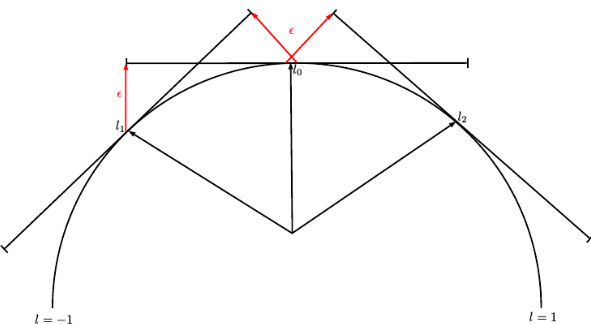

In [40]:
Image(filename="figures/non-coplanar-faceting.png")

图：旋转分块，则每个分块都同样大小。

*Figure: When the geometry of the facets are rotated the facets can all be the same size*

移动可见度的相位以后，为了使每个分块在$(l_i,m_i)$处与天球面相切，必须运用下面的旋转公式计算得出新的u',v',w'。

In order to make each facet tangent to the celestial sphere at $(l_i,m_i)$ it is necessary to employ the following rotation matrices to compute new u',v',w' coordinates **after** the visibilities have been phase shifted using the old u,v,w coordinates.
\begin{equation}
 \left[\begin{array}{c}
	u'\\
	v'\\
	w'\\
       \end{array} \right] = R(\alpha_i,\delta_i)R^{T}(\alpha_0,\delta_0)\left[\begin{array}{c}
										u\\
										v \\
										w \\
									      \end{array}
									\right]
\end{equation}

\begin{equation}
 R(\alpha,\delta) =
 \left[\begin{array}{c c c}
     -\sin{\alpha} 			& \cos{\alpha}		& 0 \\
     -\sin{\delta}\cos{\alpha} 	& -\sin{\delta}\sin{\alpha}	& \cos{\delta}\\
     \cos{\delta}\cos{\alpha} 	& \cos{\delta}\sin{\alpha}	& \sin{\delta}\\
    \end{array}\right]   
\end{equation}

分块数量大致要满足下面给出的采样规则：

The number of facets roughly needed to satisfy the sampling criterion is given as:
   
   \begin{equation}
       N_\text{facets} = \frac{2L\lambda}{{\xi}D^2}, \; \xi\ll{1}
   \end{equation}

$L$是最长基线的大小，$D$是天线口径，$\xi$是一个确定分块粒度的质量因子。

$L$ is the magnitude of the longest baseline and $D$ is the diametre of the antenna apertures. $\xi$ is a quality factor that specifies the furthest seperation allowed for the facet images from the celestial sphere. 


**w-projection：**通过把非共面测量投影到$w=0$，w-projection方法消除了相位中的$w$项。运用卷积定理，得到如下的$V(u,v,w)$跟$V(u,v,0)$间的关系式：

**W-projection:** W-projection eliminates $w$ from the phase term by relating all non-coplanar measurements to measurements taken at $w=0$. Employing the convolution theorem the following relationship between $V(u,v,w)$ and $V(u,v,0)$ can be obtained:
   
\begin{equation}
       \begin{split}
           V &= \int\int{I(l,m)e^{-2\pi i[ul+vm]}e^{-2\pi i[w(n-1)]}\frac{dldm}{n}}\\
           V &= \int\int{I(l,m)e^{-2\pi i[ul+vm]}\mathcal{w}_w(l,m)\frac{dldm}{n}}\\
           V(u,v,w) &= V(u,v,w=0)\circ\mathcal{W}_w(u,v)\\
       \end{split}
\end{equation}

这就是说，在重采样步骤中，通过从一堆预先算好的滤波器中选择出相应的$w$依赖的滤波器，任何测量结果都可以对应到同一个$uv$平面上。通常，跟窄视场成像一样，这些w滤波器会结合抗混叠滤波器一起使用。

This says that any measurement can be related to the the same $u,v$ plane during the resampling step by picking the the relevant $w$-dependent filter from a stack of precomputed filters. Normally these w-filters are combined with an anti-aliasing filter, as used in the narrow-field imaging approach.

这些$\mathcal{W}_w$滤波器的大小取决于图像尺寸，有以下关系：

The support size of these $\mathcal{W}_w$ filters are dependent on the size of the image and given by the following relation:
   
\begin{equation}
       W_\text{sup} = \frac{4\pi w_\text{max}}{\lambda} \frac{D_\text{im}^2}{\sqrt{2-D_\text{im}^2}}
\end{equation}
 
$D_\text{im}$是图像宽度。该方法的计算复杂度跟图像大小有关。
 
Here $D_\text{im}$ is the diametre of the image and shows that the computational complexity of the method depends on the size of the image.

**W-stacking:** 这是图像域的处理方法，把依赖于w的相位直接跟图像相乘：

**W-stacking:** The alternative image-domain approach (called "w-stacking") multiplies the w-dependent phase directly into the image:

1. 重采样步骤中，可见度被网格化到多个网格上（一个离散的$w$值对应一张网格）。
2. 分别对每层进行傅立叶逆变换。
3. 逐图乘以$\mathcal{w}_w(l,m)$。
4. 多图求平均，得到单张图。

1. During the resampling step the visibilties are gridded onto multiple grids (one per discretized value of $w$).
2. Each of these layers are Fourier inverted
3. The images are element-wise multiplied by $\mathcal{w}_w(l,m)$
4. The stack of images are averaged into a single image.

以下公式计算得到离散w-filters（w-projection）的数量跟图像层数（w-stacking）：

The number of discretized w-filters (w-projection) or image layers (w-stacking) are given by:
   
\begin{equation}
        N_\text{planes} = \frac{2\pi w_\text{max}(n_\text{edge}-1)}{\lambda_\text{min}\xi}, \; \xi\ll{1}
\end{equation}

W值分层越多（由质量控制因子$\xi$确定），相位改正越准确。

The more discretized layers of w-values (as controlled by the quality control factor $\xi$) used during inversion, the more accurate the phase correction becomes.

当在几度大小的视场上成像，尤其是观测阵列中有长基线的时候，成像工具中必须启用宽视场改正。如何启动宽视场模式，请查阅成像工具的文档。

***Take home point:*** When imaging over field of views several degrees in size, especially if there are long baselines in the array you are observing with, you have to enable wide-field corrections in the imaging tool you're using. Check your imager's documentation on how to enable its wide-field mode.

***

Next: [5.x References and further reading](5_x_further_reading_and_references.ipynb)

<div class=warn><b>Future Additions:</b></div>

* overview of 3D Fourier imaging